In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import pandas as pd

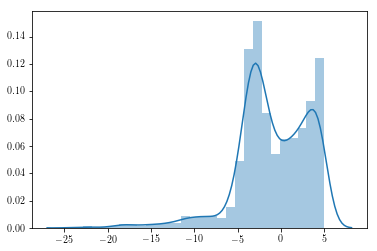

In [2]:
#Lets generate some exponentially increasing data
lambd = .2
mu = 8.
sig = 1.
Q = 500./1500.
d1 = np.random.exponential(scale = 1/lambd, size=1000)
d2 = np.random.normal(mu,sig**2,size=500)
d = np.append(d1,d2)
d = np.sort(d)*-1
d += 30
d = d[d>0.]
d -= 25.
#Flip the data
sns.distplot(d)
plt.show()


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


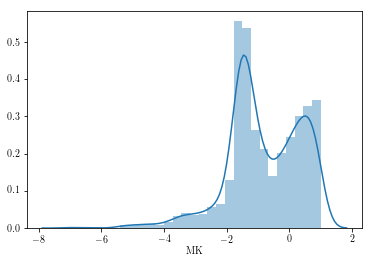

In [3]:
#Instead of using this generated data, lets run straight on the TRILEGAL sample!
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V
#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]
#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0
#Apply a cut so the exponential fits better
df = df.loc[df.MK < 1.]

d = df.MK.values
sns.distplot(df.MK)


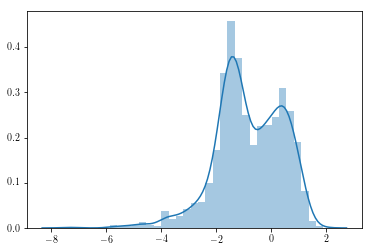

In [4]:
err = np.ones(len(d))*.3
sns.distplot(d+np.random.randn(len(df))*err)

In [5]:
code = '''
functions {
    real logexp(real x, real lambd) {
        return log(lambd) - lambd*x;
        }
    real lognormexp(real x, real c0, real c1, real lambd) {
        return log(-lambd/(c1^(-lambd)-c0^(-lambd))) - lambd*x;
    }   
    real logposexp(real x, real c0, real c1, real lambd) {
        return log(lambd/(c1^(lambd)-c0^(lambd))) + lambd*x;
    }
}
data {
    int<lower = 0> N;
    real d[N];
    real err[N];
    real c1;
    real c0;
}
parameters {
    real lambd;
    real mu;
    real <lower=0.> sig;
    real <lower=0.,upper=1.> Q;
    real d_true[N];
}
model {
    d_true ~ normal(d, err);

    lambd ~ normal(0.2,0.1);
    mu ~ normal(-3.,1.);
    sig ~ normal(1.,0.1);
    Q ~ normal(0.5,.1);

    for (n in 1:N)
        target += log_mix(Q,
            normal_lpdf(d[n] | mu, sig),
            logposexp(d[n] ,c0, c1, lambd));
}
generated quantities{
    vector[N] post_prob;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(d[n] | mu, sig);
        ll_bg = log(1-Q) + logposexp(d[n], c0, c1, lambd);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
    }
}

'''
sm = pystan.StanModel(model_code = code, model_name='exp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL exp_9ce663fb42ae68f42e38abf8fd5f1ab7 NOW.


In [6]:
dat = {'N': len(d),
      'd': d,
      'err' : err,
      'c1' : np.exp(d.max()),
      'c0' : np.exp(d.min())}
fit = sm.sampling(data=dat, iter=3000, chains=1)


/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


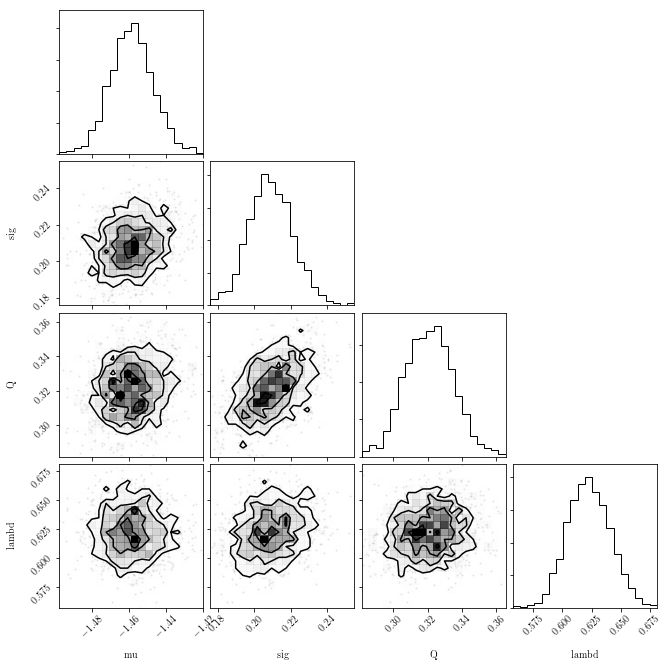

0.3209233417191188
8.0


In [7]:
trace = fit.extract()
chain = np.array([trace['mu'],trace['sig'],trace['Q'],trace['lambd']])
truths = [-3., sig, Q, lambd]
import corner
corner.corner(chain.T,labels=['mu','sig','Q','lambd'])
plt.show()
print(np.median(trace['Q']))
print(mu)

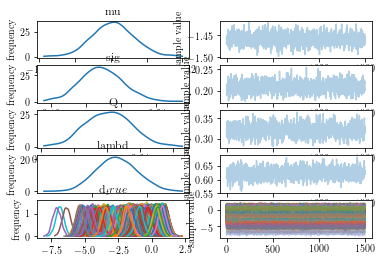

In [8]:
fit.plot(pars=['mu','sig','Q','lambd','d_true'])
plt.show()

In [9]:
trace = fit.extract()
Slambd = np.median(trace['lambd'])
Smu = np.median(trace['mu'])
Ssig = np.median(trace['sig'])
SQ = np.median(trace['Q'])
tpp = trace['post_prob']
post_prob = np.sum(tpp,axis=0)/tpp.shape[0]

bg = (Slambd/(np.exp(d.max())**Slambd - np.exp(d.min())**Slambd))*np.exp(d*Slambd)
fg = (1/np.sqrt(2*np.pi*Ssig**2))*np.exp(-(d-Smu)**2/(2*Ssig**2))
L = SQ*fg + (1-SQ)*bg

Text(0,0.5,u'Units arbitrary')

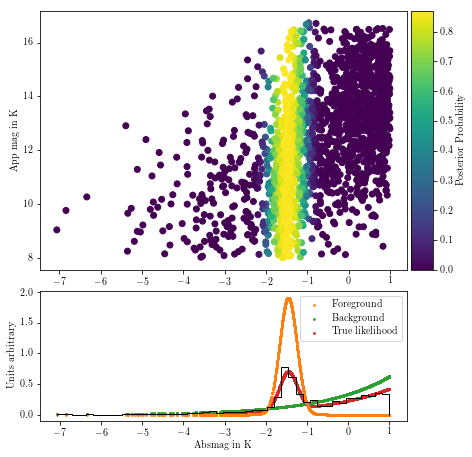

In [10]:
left, bottom, width, height = 0.1, 0.45, 0.85, 0.60
fig = plt.figure(1, figsize=(6,6))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])
cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(d,df.K,c=post_prob)
fig.colorbar(c, cax=cax, label='Posterior Probability')
xax.hist(d, histtype='step', bins='sqrt',color='k',normed=True,zorder=1000)

xax.scatter(d,fg,s=3,label='Foreground', zorder=999)
xax.scatter(d,bg,s=3,label='Background', zorder=998)
xax.scatter(d, L,s=3,label='True likelihood', zorder=997)
xax.legend()

xax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

NameError: name 'pp' is not defined

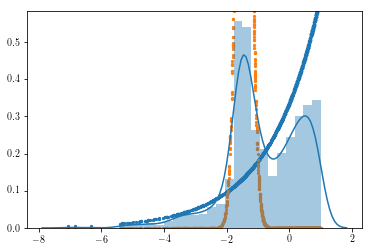

In [11]:
sns.distplot(d)
plt.scatter(d, bg,s=5)
plt.scatter(d, fg,s=5)
plt.scatter(d, pp,s=5)
print(mu)

In [ ]:
'''Now lets make a gaussian'''
true_m = 1.
true_sig = 2.
d = np.random.normal(true_m,true_sig,size=2000)
d = d[d<0.]
sns.distplot(d)
plt.show()

In [ ]:
code = '''
functions {
    real logposexp(real x, real hi, real lo, real lambd) {
        real A;
        A = log(lambd*(exp(lambd*hi)-exp(lambd*lo))^-1);
        return lambd*x + A;
        }
        
    real 
}
data {
    int<lower = 0> N;
    real d[N];
}
parameters {
    real lambd;
}
model {
    lambd ~ normal(0, 1e6);
    for (n in 1:N)
        target += logposexp(d[n], max(d), min(d), lambd);
}

'''
sm = pystan.StanModel(model_code = code, model_name='offgauss')

In [ ]:
dat = {'N': len(d),
      'd': d}
fit = sm.sampling(data=dat, iter=1000, chains=1)

In [ ]:
fit.plot()
plt.show()

In [ ]:
trace = fit.extract()
lambd = np.median(trace['lambd'])
sns.distplot(d)
p = (lambd*(np.exp(lambd*d.max()) - np.exp(lambd*d.min()))**-1)\
                                               *np.exp(lambd*d)
plt.scatter(d,p)

In [ ]:
import pandas as pd
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df.head(5)
print(df.columns)
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V\
#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]
#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0
df1 = df[df.MK < -1.8]
df2 = df[df.MK > -1.]
dfn = pd.concat([df1,df2])
#Plot absolute magnitude in K
sns.distplot(dfn.MK)


In [ ]:
dat = {'N': len(df.MK),
      'd': df.MK}
fit = sm.sampling(data=dat, iter=1000, chains=1)

In [ ]:
fit.plot()
plt.show()

In [ ]:
trace = fit.extract()
lambd = np.median(trace['lambd'])
sns.distplot(dfn.MK)
p = (lambd*(np.exp(lambd*dfn.MK.max()) - np.exp(lambd*dfn.MK.min()))**-1)\
                                               *np.exp(lambd*dfn.MK)
plt.scatter(dfn.MK,p)

In [ ]:
print(lambd)

In [ ]:
len(dfn)

In [ ]:
len(df)

In [ ]:
1.-(1434./2192.)

In [ ]:
np.median(df)

In [ ]:
np.median(df.MK[df.MK<-1.45])


In [ ]:
x = np.linspace(d.min(),d.max())
y = np.exp(-.4*x)
plt.plot(x,y)
plt.show()
d.min()
d.max()

In [ ]:
%pylab qt
fit.plot(pars=['mu','sig','Q','lambd','d_true'])
plt.show()

In [ ]:
%pylab inline